In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.transform as sktr
import skimage.io as skio
from skimage import draw
from skimage import transform
import scipy
from tqdm import tqdm

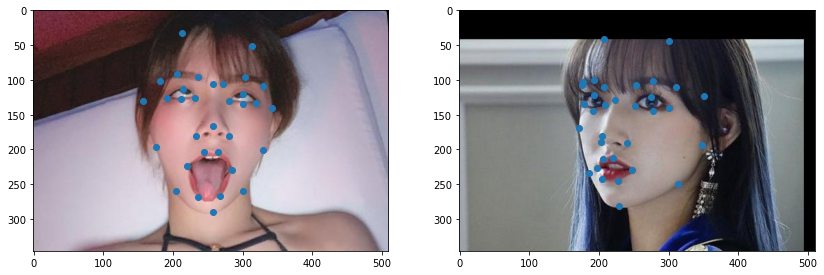

In [2]:
# read & mark corresponding points
img1 = skio.imread('alimg1.jpg')
img1 = sk.img_as_float(img1)
img2 = skio.imread('alimg2.jpg')
img2 = sk.img_as_float(img2)

pts1 = np.load('alimg1_pts.npy',allow_pickle=True)
pd = pts1.item()
p1 = np.array([i for l in pd.values() for i in l])
p1 = np.ndarray.round(p1)
pts2 = np.load('alimg2_pts.npy',allow_pickle=True)
pd = pts2.item()
p2 = np.array([i for l in pd.values() for i in l])
p2 = np.ndarray.round(p2)


fig,ax = plt.subplots(ncols=2,figsize=(14,10))
ax[0].imshow(img1)
ax[0].scatter(p1[:,0],p1[:,1])
ax[1].imshow(img2)
ax[1].scatter(p2[:,0],p2[:,1])

Text(0.5, 1.0, 'Tri with avg points')

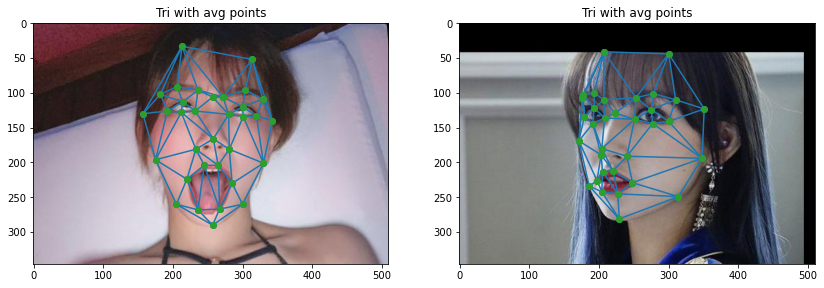

In [3]:
# triangulation with image 1 points
from scipy.spatial import Delaunay
points = (p1+p2)/2
tri = Delaunay(points)


points = (p1 + p2)/2
fig,ax = plt.subplots(ncols=2,figsize=(14,10))
tri = Delaunay(points)
ax[0].imshow(img1)
ax[0].scatter(p1[:,0],p1[:,1])
ax[0].triplot(p1[:,0],p1[:,1],tri.simplices)
ax[0].plot(p1[:,0],p1[:,1],'o')
ax[0].set_title('Tri with avg points')
ax[1].imshow(img2)
ax[1].scatter(p2[:,0],p2[:,1])
ax[1].triplot(p2[:,0], p2[:,1], tri.simplices)
ax[1].plot(p2[:,0], p2[:,1], 'o')
ax[1].set_title('Tri with avg points')

In [4]:
# uses linear algebra to solve the affine transform matrix, note that we uses its inverse
def computeAffine(tri1_pts,tri2_pts):
    src,dst = tri1_pts,tri2_pts
    x1 = np.pad(src.transpose(1,0),[(0,1),(0,0)],mode='constant',constant_values=1)
    x2 = np.pad(dst.transpose(1,0),[(0,1),(0,0)],mode='constant',constant_values=1)
    T = x2 @ np.linalg.inv(x1)
    return T
def pos_of_interest(tri_target,T):
    dst = tri_target
    tu1 = draw.polygon(dst[:,0],dst[:,1])
    new_src = tuple(np.ndarray.round((np.linalg.inv(T) @ np.pad(np.array(tu1),[(0,1),(0,0)],mode='constant',constant_values=1))[:2]).astype(int))
    return tu1[::-1], new_src[::-1]

# use corresponding points to get triangles once and fixed through morphing process
tri = Delaunay((p1+p2)/2)

def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    
    img1,img2,p1,p2 = im1,im2,im1_pts,im2_pts
    # warped shape according to warp_frac
    warped_pts = warp_frac*p1+(1-warp_frac)*p2
    # initialize two mid-way images
    new_img1 = (img1+img2)/2
    new_img2 = (img1+img2)/2
    # obtain Mid-way images
    for indices in tri.simplices:
        # use the corresponding feature triangle to estimate the affine transformation matrix
        from_src,to_dst = p2[indices],warped_pts[indices]
        T2 = computeAffine(from_src,to_dst)
        # new morphing image's dst_position is filled with src_position from the old images (hybrid of src&dst)
        to_img_dst, from_img_src = pos_of_interest(to_dst,T2)
        # mid-way image part I
        new_img2[to_img_dst] = img2[from_img_src]    
        # from img1 to mid-way
        from_src,to_dst = p1[indices],warped_pts[indices]
        T1 = computeAffine(from_src,to_dst)
        # new morphing image's dst_position is filled with src_position from the old images (hybrid of src&dst)
        to_img_dst, from_img_src = pos_of_interest(to_dst,T1)
        # mid-way image
        new_img1[to_img_dst] = img1[from_img_src]
    # cross-dissolve
    mid_img = dissolve_frac*new_img1 + (1-dissolve_frac)*new_img2
    return mid_img

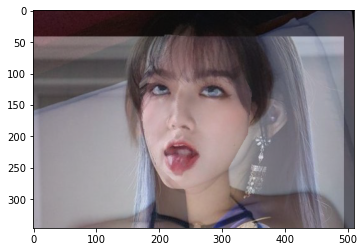

In [5]:
mids = morph(img1,img2,p1,p2,tri,warp_frac=0.4,dissolve_frac=0.5)
plt.imshow(mids)

In [54]:
# time frame morphing
num_steps = 100
imgs = []
for t in tqdm(np.linspace(0,1,num_steps)):
    mid_img = morph(img1,img2,p1,p2,tri,warp_frac=t,dissolve_frac=0.5)
    imgs.append(mid_img)

100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


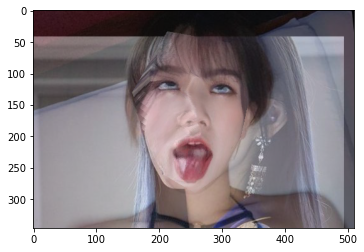

In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

#img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(num_steps):
    frames.append([plt.imshow(imgs[i], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')
#plt.show()